In [1]:
import scanpy as sc
import graph_tool.all as gt
import scnsbm
import pandas as pd
import anndata
import mygene
import pickle
import scipy.stats
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [18]:
sc.settings.set_figure_params(dpi=300, facecolor='white')

# NSBM correctly identifies cell populations

In [2]:
df = pd.read_table("../../../../../sc_mixology/data/csv/sc_10x_5cl.count.csv.gz", compression="gzip", sep=",")

### Preprocessing

In [3]:
adata = anndata.AnnData(df.T)
cell_cycle_genes = [x.strip() for x in open('../../../../../sc_mixology/regev_lab_cell_cycle_genes.txt')]

In [4]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

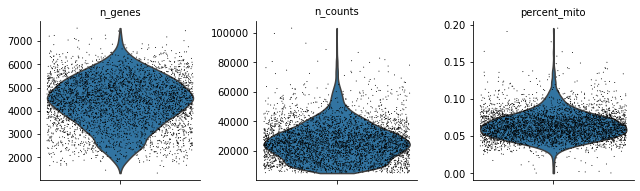

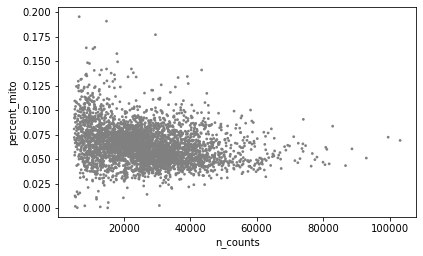

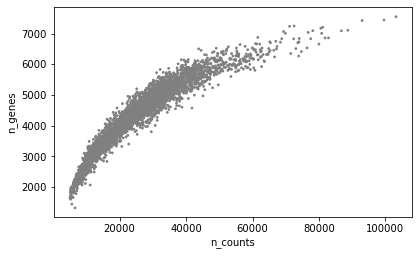

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)


np.sum(adata[:, mito_genes].X, axis=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [6]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, copying.


In [7]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

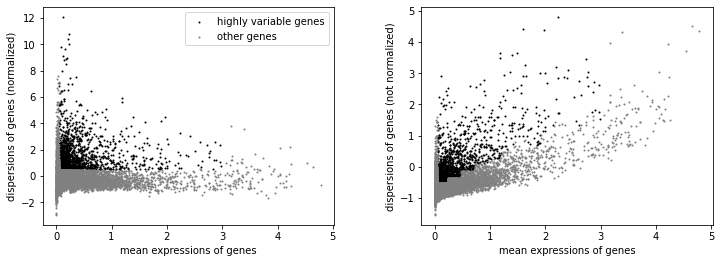

In [8]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [9]:
adata = adata[:, adata.var['highly_variable']]

In [10]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:1171: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


### Cell annotation

In [11]:
cell_annotation= pd.read_table('../../../../../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)

In [13]:
adata.obs.loc[:, "cell_line_demuxlet"] = cell_annotation.loc[adata.obs_names, "cell_line_demuxlet"]

In [14]:
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

### Principal component analysis and neighborhood graph computation

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

In [77]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

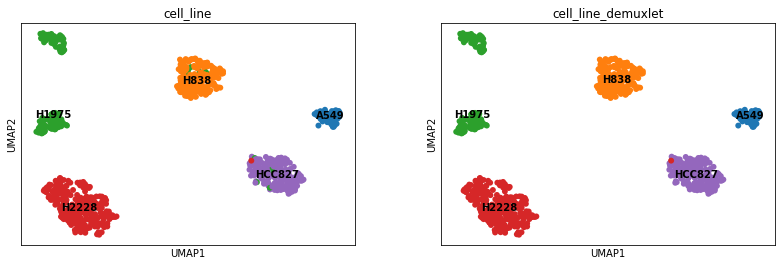

In [78]:
ciao=sc.pl.umap(adata, color=['cell_line','cell_line_demuxlet'],legend_loc='on data')

# Clustering the neighborhood graph with leiden algorithm
Clustering analysis is performed with leiden algorithm.
Changes the resolution parameter of leiden lead to changes in clustering of data: the higher the parameter, the higher the number of clusters. In order to find the best possible partition obtained through leiden algorithm we tried to set each possible value of the resolution parameter from 0.01 to 1. 


Moving the resolution parameter between 0.97-0.99 the situation remains similar: the only difference is that H2228 cell-line is now split into 2 groups (group 0 and 4).

Setting the resolution parameter from 0.39 to 0.96 overclustering is still witnessed, but now the only two cell-lines affected are H82228 and H1975, both divided into 2 groups.

When the resolution parameter ranges between 0.38 and 0.05 the only cell-type that present overclustering is H1975 which is still split into two groups.

However it is at resolution lower than 0.05 that we can observe a misclassification of cell-lines: in fact, leiden algorithm merged in the same group A549 cell-line and H838 cell_line, but H1975 cell-line is still split into 2 different group. This means that leiden algorithm finds more similar 2 different cell-lines compared to 2 subpopulations of the same cell type.



In [79]:
sc.tl.umap(adata)

In [80]:
sc.tl.leiden(adata)

If the resolution parameter is set at the default value of 1 we can observe the phenomenon of overclustering: in particular, H1975 cell-line is split into 2 clusters and  H2228 cell-line is divided into 2 separated groups. The situation remain the same for each value between 0.47 and 1

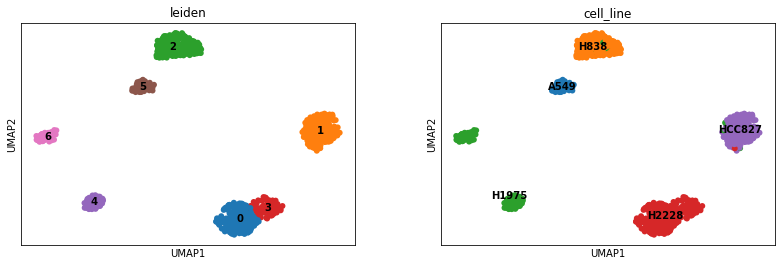

In [93]:
sc.tl.leiden(adata, resolution=1)
sc.pl.umap(adata, color=['leiden','cell_line'], legend_loc='on data')

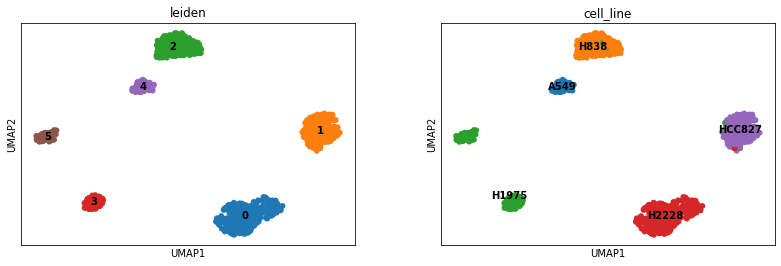

In [3]:
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color=['leiden','cell_line'], legend_loc='on data')

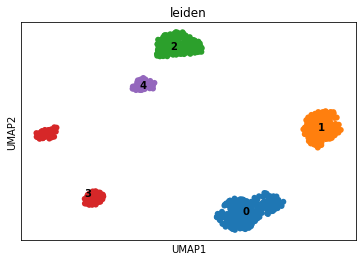

In [4]:
sc.tl.leiden(adata, resolution=0.04)
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')

# Clustering the neighborhood graph with scnsbm
clustering analysis is performed with scNSBM

In [27]:
scnsbm.inference.nested_model(adata,equilibrate=False, deg_corr=True,n_init=3)

In [28]:
scnsbm.io.write(adata, prefix='../clustering_data/mixology10x')

In [2]:
adata=scnsbm.io.read('../clustering_data/mixology10x')

When we have analyzed the same data with our scNSBM library, we have obtained a hierarchy of 10 levels, each one characterized by a more and more agglomerated profile and modularity measure. The selection of the right level of the hierarchy relies on the modularity measure: the level with the best clustering profile is the one with the highest modularity (Fig. 1d); in our case level 2 was the chosen one

<BarContainer object of 10 artists>

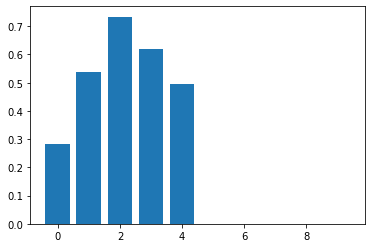

In [30]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

Clusters of level 2 respected very well resemble very precisely the ground truth; moreover, NSBM model seemed to capture also a small group within HCC827 cell_line that present a cell recognized as H2228 in the ground truth.

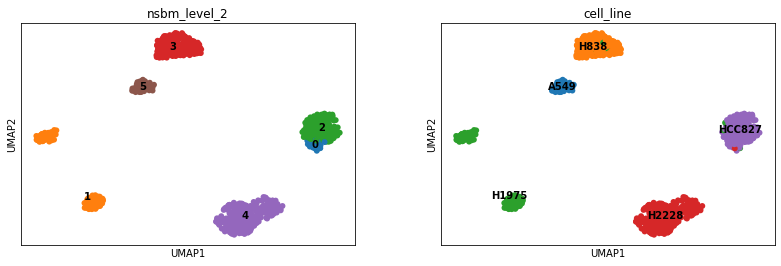

In [85]:
sc.pl.umap(adata, color=['nsbm_level_2','cell_line'], legend_loc='on data')

Observing the 3rd level of the hierarchy, which showed an high value of modularity too, we have noticed that A549 cell-line and H838 cell-line have been merged together as well as in Leiden clustering, when resolution parameter was 0.04

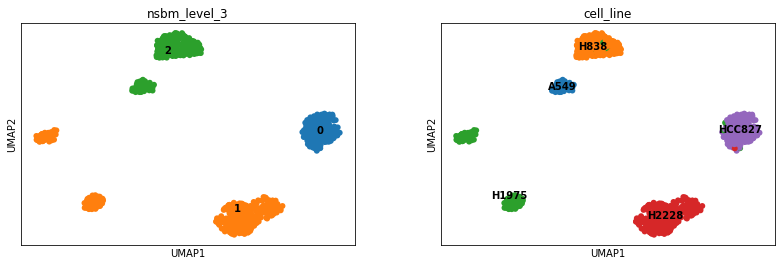

In [86]:
sc.pl.umap(adata, color=['nsbm_level_3','cell_line'], legend_loc='on data')

From these acquisitions, we can conclude that there may be an intrinsic heterogeneity inside each cell-line that could lead to the split of a cell-line in different groups; furthermore, probably A549 cells and H838 cells have some similarities. However, it is extremely difficult to obtain consistent results, analyzing these data with Leiden algorithm, not only due to the resolution parameter issue, but also because of the under-clustering and the consequent misclassification of A549 and H838 cell lines. On the other hand with scNSBM library the level of the hierarchy with the highest modularity measure is also the one that better explain data, according to the ground true. Moreover, similarities between cell-lines are represented at higher levels of the hierarchy. For this reason we can conclude that NSBM correctly identifies cell populations.